Number of reference keypoints detected:  500
Number of align image keypoints detected:  500


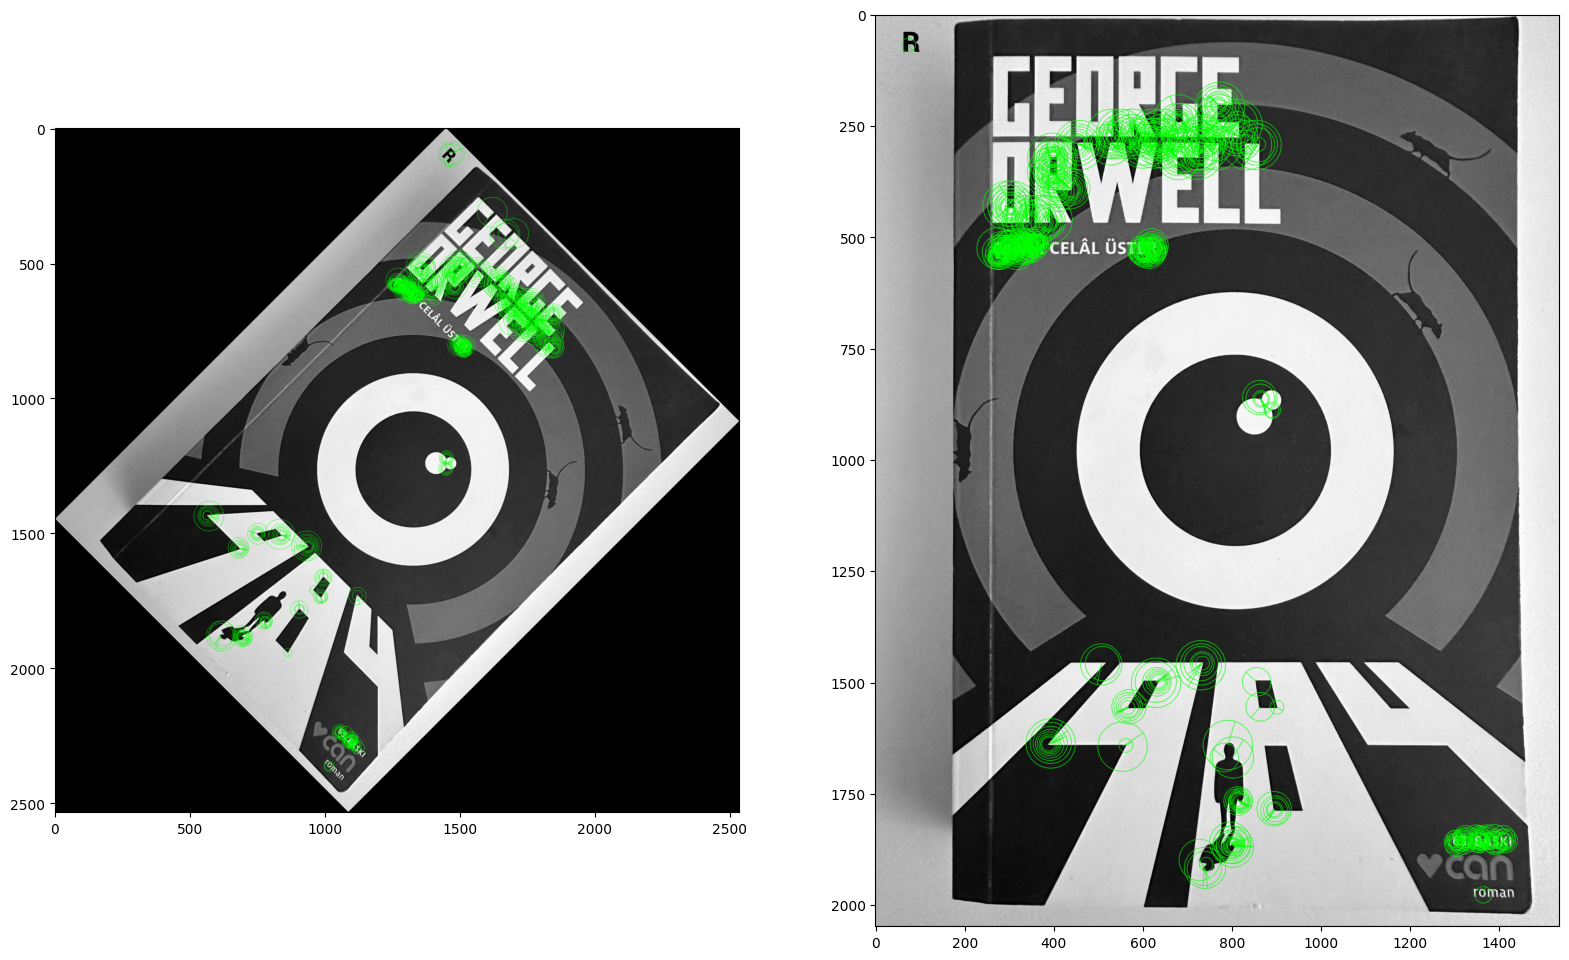

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils

def resize_image_with_fixed_height(img, desiredHeight):

    height, width = img.shape[:2]
    aspect_ratio = width / height
    new_width = int(desiredHeight * aspect_ratio)

    return cv2.resize(img, (new_width, desiredHeight))

desiredHeight = 400

# imgAlign = cv2.imread('./oldImages/george6.jpeg', cv2.IMREAD_GRAYSCALE)
imgReference = cv2.imread('./images/george1e.jpeg', cv2.IMREAD_GRAYSCALE)
imgAlign = imutils.rotate_bound(imgReference, 45)


# imgReference = resize_image_with_fixed_height(imgReference, desiredHeight)
# imgAlign = resize_image_with_fixed_height(imgAlign, desiredHeight)

# imgAlign = imutils.rotate_bound(imgReference, 45)
# imgAlign = cv2.resize(imgReference, None, fx=1.5, fy=1.5, interpolation=cv2.INTER_CUBIC)

# imgAlign = cv2.imread('./images/salt-and-pepper-george.jpeg', cv2.IMREAD_GRAYSCALE)

h, w = imgAlign.shape
orb = cv2.ORB_create()

referenceKp, referenceDes = orb.detectAndCompute(imgReference, None)
alignKp, alignDes = orb.detectAndCompute(imgAlign, None)

DimgReference = cv2.drawKeypoints(imgReference, referenceKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
DimgAlign = cv2.drawKeypoints(imgAlign, alignKp, None, color=(0, 255, 0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print("Number of reference keypoints detected: ", len(referenceKp))
print("Number of align image keypoints detected: ", len(alignKp))

plt.figure(figsize=(30, 30))
plt.subplot(132)
plt.imshow(DimgReference)
plt.subplot(131)
plt.imshow(DimgAlign)
plt.show()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


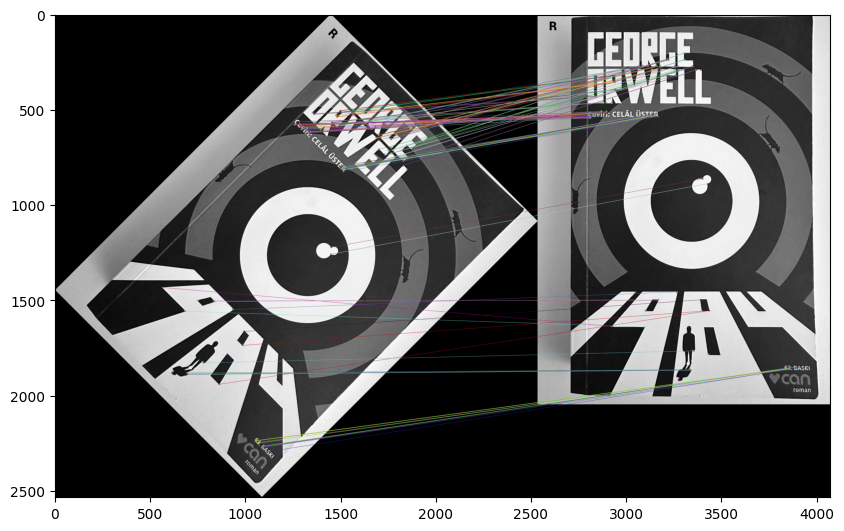

(<matplotlib.image.AxesImage at 0x7f382c0eb6a0>, None)

In [5]:
print(type(alignDes))
print(type(referenceDes))

matcher = cv2.BFMatcher()
Matches = matcher.knnMatch(alignDes, referenceDes, k=2)

newMatchings = []
for m, n in Matches:
    if m.distance < 0.75*n.distance:
        newMatchings.append(m)

matchedImage = cv2.drawMatches(imgAlign, alignKp, imgReference, referenceKp, newMatchings, None)
plt.figure(figsize=(10, 10))
plt.imshow(matchedImage, 'gray'), plt.show()

Homografi matrisi: 
[[ 7.16952683e-01  7.17825779e-01 -1.03989392e+03]
 [-7.13979417e-01  7.19328910e-01  1.03038171e+03]
 [ 4.48499597e-06  5.61123785e-06  1.00000000e+00]]
Dönüş Açısı: -44.880947976380476 derece


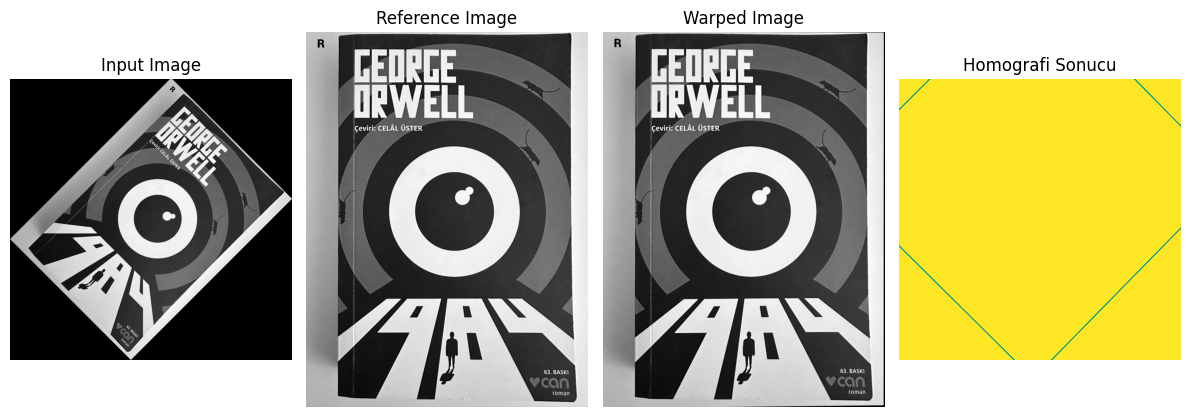

In [6]:
def find_rotation_angle(src_pts, dst_pts):
    M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    angle_rad = np.arctan2(M[1, 0], M[0, 0])
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

# [[cos(theta), -sin(theta), tx],
#  [sin(theta), cos(theta),  ty],
#  [0,          0,           1]]

src_pts = []
dst_pts = []

for match in newMatchings:
    src_pts.append(alignKp[match.queryIdx].pt)
    dst_pts.append(referenceKp[match.trainIdx].pt)

src_pts = np.float32(src_pts).reshape(-1, 1, 2)
dst_pts = np.float32(dst_pts).reshape(-1, 1, 2)

M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

if M is None:
    print("Homografi bulunamadı.")

print(f"Homografi matrisi: \n{M}")

offsetX = 400
offsetY = 200

pts = np.float32([
    [offsetX, offsetY],
    [offsetX, h  + offsetY],
    [w + offsetX, h  + offsetY],
    [w + offsetX, offsetY]
]).reshape(-1, 1, 2)

dst = cv2.perspectiveTransform(pts, M)

im1_reg = cv2.warpPerspective(imgAlign, M, (imgReference.shape[1], imgReference.shape[0]))

empty_frame = np.ones((2500, 2500), dtype=np.uint8) * 255
empty_frame = cv2.polylines(empty_frame, [np.int32(dst)], True, 122, 3, cv2.LINE_AA)

rotation_angle = find_rotation_angle(src_pts, dst_pts)
print(f"Dönüş Açısı: {rotation_angle} derece")

plt.figure(figsize=(12, 6))
plt.subplot(141), plt.imshow(imgAlign, cmap='gray')
plt.title('Input Image'), plt.axis('off')

plt.subplot(142), plt.imshow(imgReference, cmap='gray')
plt.title('Reference Image'), plt.axis('off')

plt.subplot(143), plt.imshow(im1_reg, cmap='gray')
plt.title('Warped Image'), plt.axis('off')

plt.subplot(144), plt.imshow(empty_frame)
plt.title('Homografi Sonucu'), plt.axis('off')


plt.tight_layout()
plt.show()
